In [465]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import astra
import pywt

from tqdm import tqdm

%matplotlib inline

# Part B

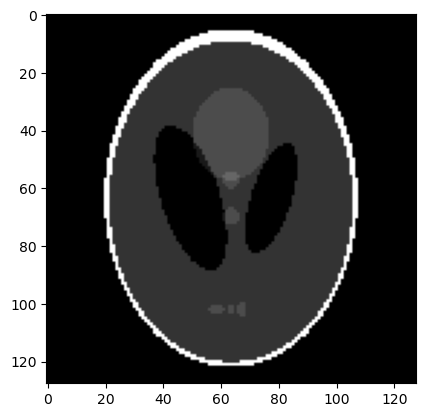

In [466]:
# Load data
SLphantom = np.load('../data/SLphan.npy')

f_true = SLphantom
plt.imshow(f_true, cmap='gray')

In [467]:
def Randon_Transform(f, angles, det_count=128, detector_spacing=1.):
    # Create volume geometries
    v, h = f.shape
    vol_geom = astra.create_vol_geom(v, h)

    # Create projector geometries

    # det_count = int(v / detector_spacing)count, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, det_count, angles)

    # Create projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Radon transform (generate sinogram)
    sinogram_id, sinogram = astra.create_sino(f, projector_id)

    return vol_geom, proj_geom, projector_id, sinogram_id, sinogram

def Radon_Back_Proj(vol_geom, sinogram_id, projector_id, ptype='BP'):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(ptype)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

#### Create sinogram with missing measurements

In [468]:
def create_undersampled(obj, n_projs, proj_space):
    # n_projs: int, proj_space: int
    # n_projs % proj_space == 0
    angles = np.linspace(0, np.pi, 180, endpoint=False)
    vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(obj, angles, n_projs // proj_space, proj_space)
    g_us = np.zeros((180, n_projs))
    mask = np.zeros((180, n_projs))
    g_us[:, 0:n_projs:proj_space] = g
    mask[:, 0:n_projs:proj_space] = np.ones_like(g)
    rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
    return g_us, mask, rec

def create_limited_angles(obj, degree, n_projs):
    # degree: int [0, 90], n_projs: int
    # n_projs % proj_space == 0
    angles = np.hstack((
        np.linspace(0, np.pi * degree / 180., degree, endpoint=False),
        np.linspace(np.pi * (1. - degree / 180.), np.pi, degree, endpoint=False)
    ))
    vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(obj, angles, n_projs, 1)
    g_la = np.zeros((180, n_projs))
    mask = np.zeros((180, n_projs))
    g_la[:degree] = g[:degree]
    g_la[180-degree:] = g[degree:]
    mask[:degree] = np.ones_like(g[:degree])
    mask[180-degree:] = np.ones_like(g[degree:])
    rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
    return g_la, mask, rec

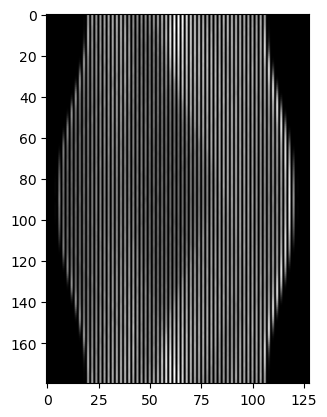

In [469]:
g_us, mask_us, rec_us = create_undersampled(f_true, 128, 2)
plt.imshow(g_us, cmap='gray')

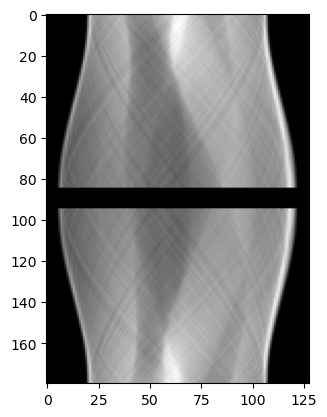

In [470]:
g_la, mask_la, rec_la = create_limited_angles(f_true, 85, 128)
plt.imshow(g_la, cmap='gray')

#### Inpainting based on an istotropic Laplacian

In [272]:
def construct_masking_operator(mask):
    mf = mask.flatten()
    col_idx = np.where(mf==1)[0]
    row_idx = np.arange(col_idx.shape[0])
    data = np.ones_like(col_idx)
    return scipy.sparse.csr_matrix((data, (row_idx, col_idx)), shape=(row_idx.shape[0], mf.shape[0]))

def construct_delta_xy(h, w):
    d = scipy.sparse.diags([1, -1], [0, 1], shape=(w, w))
    ri = np.eye(h)
    gx = scipy.sparse.kron(ri, d)
    gy = scipy.sparse.kron(d, ri)
    return gx, gy

def apply_gradient_to_image(g, im):
    h, w = im.shape
    imv = im.reshape((h * w,))
    gim = g @ imv
    return gim.reshape((h, w))

def solve_with_l1_reg(alpha, A, g, h, w):
    gx, gy = construct_delta_xy(h, w)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [401]:
im = plt.imread('../data/house.png')
mask_h = np.ones((256, 256))
mask_h[65:90,60:110] = 0
mask_h[140:155,175:200] = 0
mask_h[210:240,155:195] = 0
mim = mask_h * im

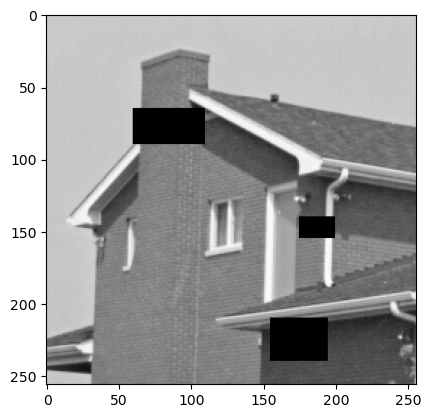

In [243]:
plt.imshow(mim, cmap='gray')

Status: 2
Iteration number: 168



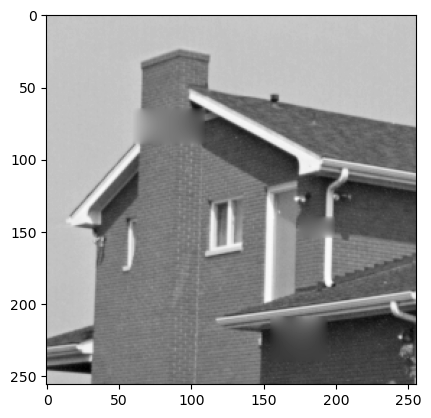

In [403]:
us_h, us_w = im.shape
A = construct_masking_operator(mask_h)
g = A @ im.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

In [476]:
us_h, us_w = g_us.shape
A = construct_masking_operator(mask_us)
g = A @ g_us.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)

Status: 2
Iteration number: 18



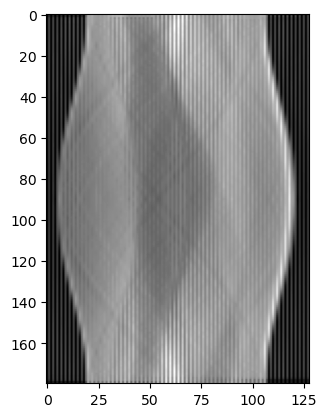

In [477]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

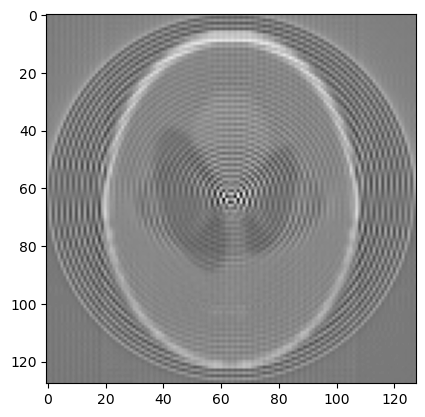

In [478]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

In [480]:
la_h, la_w = g_la.shape
A = construct_masking_operator(mask_la)
g = A @ g_la.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)

Status: 2
Iteration number: 58



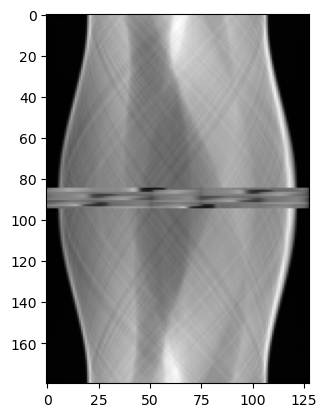

In [481]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

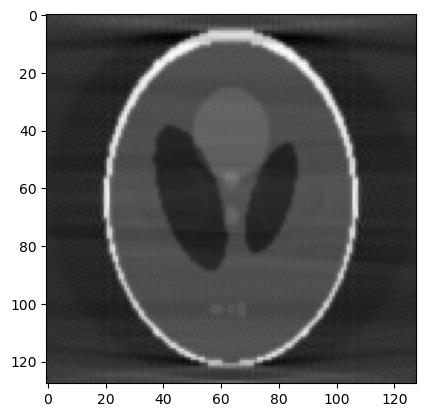

In [482]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

#### Filter the corrected sinograms

Status: 2
Iteration number: 18



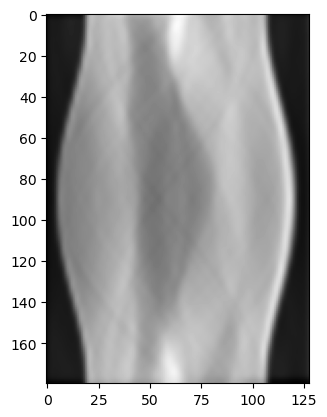

In [483]:
us_h, us_w = g_us.shape
A = construct_masking_operator(mask_us)
g = A @ g_us.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=1.2)
plt.imshow(f_rec_lsqr, cmap='gray')

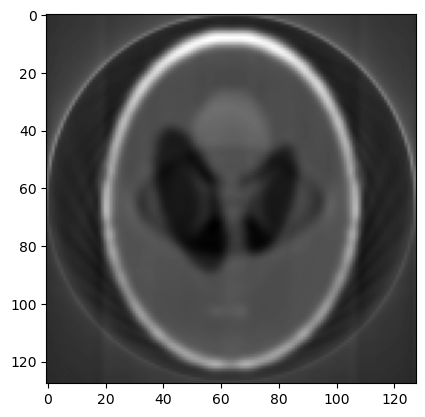

In [484]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

Status: 2
Iteration number: 58



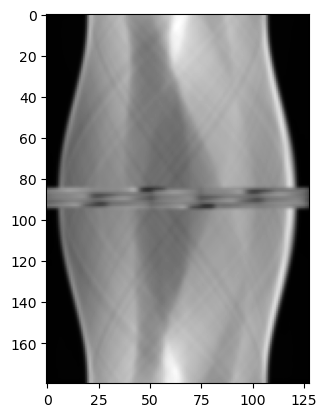

In [488]:
la_h, la_w = g_la.shape
A = construct_masking_operator(mask_la)
g = A @ g_la.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=0.8)
plt.imshow(f_rec_lsqr, cmap='gray')

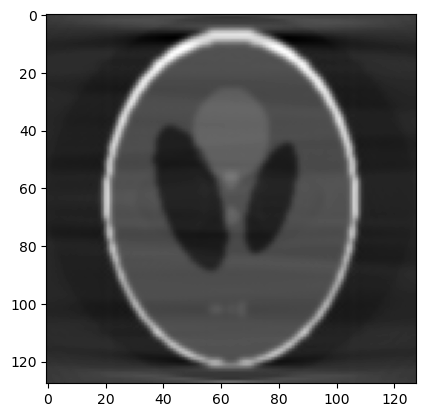

In [489]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

#### Use an anisotropic regulariser

In [453]:
def construct_gamma_delta(f):
    h, w = f.shape
    gx, gy = construct_delta_xy(h, w)
    
    ff = f.flatten()
    gfx = gx @ ff
    gfy = gy @ ff
    T = np.linalg.norm(np.sqrt(gfx * gfx + gfy * gfy)) / 1000
    gamma_d = np.exp(-np.sqrt(gfx * gfx + gfy * gfy) / T)
    gamma = scipy.sparse.diags(gamma_d)

    return np.sqrt(gamma) @ gx, np.sqrt(gamma) @ gy

In [490]:
def solve_with_af(alpha, A, g, f):
    gx, gy = construct_gamma_delta(f)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

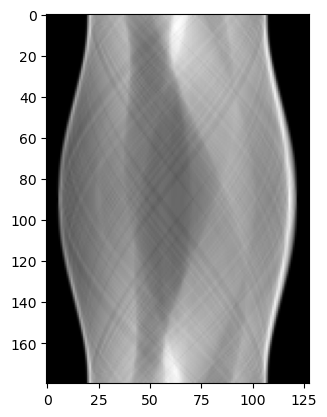

In [499]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, projector_id, sinogram_id, sinogram = Randon_Transform(f_true, angles, 128)
g_true = sinogram
plt.imshow(g_true, cmap='gray')

Status: 2
Iteration number: 1338



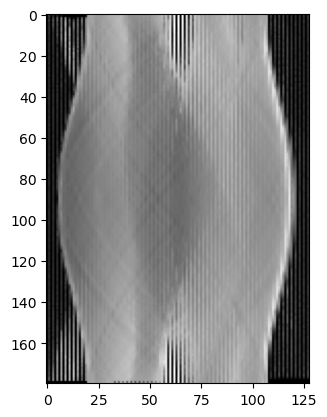

In [524]:
us_h, us_w = g_us.shape
A = construct_masking_operator(mask_us)
g = A @ g_us.flatten()
x_lsqr = solve_with_af(1e-2, A, g, g_true)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

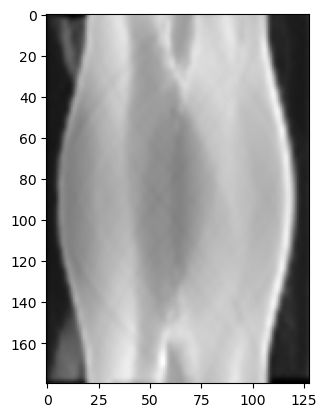

In [525]:
f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=1.2)
plt.imshow(f_rec_lsqr, cmap='gray')

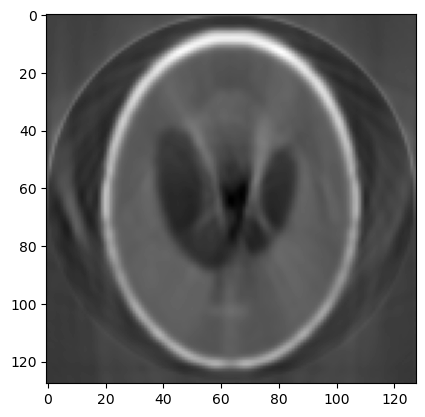

In [526]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

Status: 2
Iteration number: 366



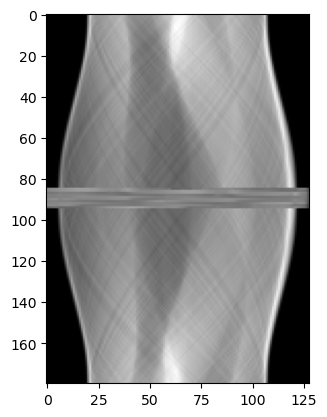

In [513]:
la_h, la_w = g_la.shape
A = construct_masking_operator(mask_la)
g = A @ g_la.flatten()
x_lsqr = solve_with_af(1e-1, A, g, g_true)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((la_h, la_w))
plt.imshow(f_rec_lsqr, cmap='gray')

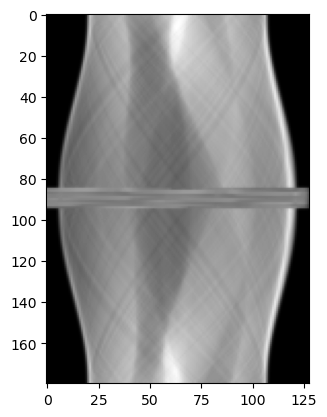

In [514]:
f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=0.5)
plt.imshow(f_rec_lsqr, cmap='gray')

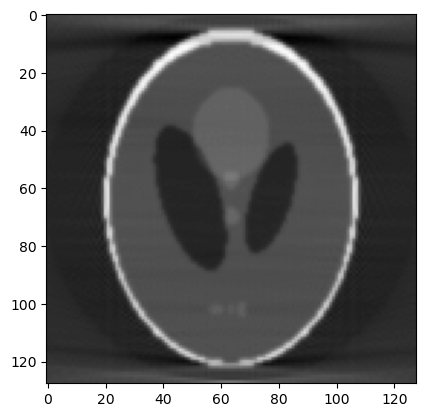

In [515]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
plt.imshow(rec, cmap='gray')

Status: 2
Iteration number: 991



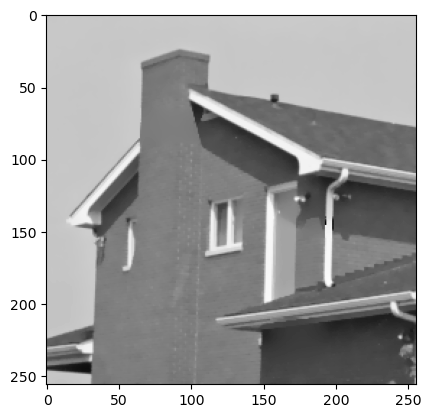

In [516]:
us_h, us_w = im.shape
A = construct_masking_operator(mask_h)
g = A @ im.flatten()
x_lsqr = solve_with_af(10, A, g, im)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')